In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#resizes an image and displays it
def imshow(image):
    scaled_image = cv2.resize(image, (960, 540), interpolation=cv2.INTER_AREA)
    #scaled_image = image
    cv2.imshow("work_work", scaled_image)
    cv2.waitKey(0) 
    cv2.destroyAllWindows()
    
def imshow_unscaled(image):
    cv2.imshow("work_work", image)
    cv2.waitKey(0) 
    cv2.destroyAllWindows()
    
#returns lines detected by the hough transform
def hough_transform(edges):
  lines = cv2.HoughLines(edges,1,np.pi/180,100)
  lines = lines[:, 0, :]
  return lines

#draws lines over the dest image
def draw_lines(lines, dest):
    lines_length = len(lines)
    line_length = 10000
    for i in range(lines_length):
        rho = lines[i][0]
        theta = lines[i][1]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + line_length*(-b))
        y1 = int(y0 + line_length*(a))
        x2 = int(x0 - line_length*(-b))
        y2 = int(y0 - line_length*(a))
        cv2.line(dest,(x1,y1),(x2,y2),(255),1)
    return

#function taken from
#https://stackoverflow.com/questions/4292249/automatic-calculation-of-low-and-high-thresholds-for-the-canny-operation-in-open
#performs canny edge detection using automatically calculated thresholds
def auto_canny(image, sigma=0.33):
    # compute the median of the single channel pixel intensities
    v = np.median(image)
    # apply automatic Canny edge detection using the computed median
    t1 = int(max(0, (1.0 - sigma) * v))
    t2 = int(min(255, (1.0 + sigma) * v))
    edge_image = cv2.Canny(image, t1, t2)

    # return the edged image
    return edge_image

#TODO: improve line detection to avoid rogue lines
#detects lines in an image and draws them over the dest
def lines_detection(image, dest):
  k_size = 7
  blurred_image = cv2.GaussianBlur(image,(k_size, k_size),cv2.BORDER_DEFAULT)
  #imshow(blurred_image)
  edge_image = auto_canny(blurred_image)
  #edge_image = cv2.Canny(image, 100, 200)
  lines = hough_transform(edge_image)
  #print(lines)
  draw_lines(lines, dest)
  return lines #returns the line coordinates

#on chessboards, k should be 18 (9 vertical lines, 9 horizontal)
#in this case, our plan is to cluster vertical and horizontal lines, then do 2 new 9-line clusters
#the plan failed, but we keep the idea to get vertical and horizontal lines into separate grou
#points is a np.array of points (from hough transform)
def initialize_centroids(points, k):
    """returns k random centroids from the initial points"""
    centroids = points.copy()
    np.random.shuffle(centroids)
    return centroids[:k]

def closest_centroid(points, centroids):
    """returns an array containing the index to the nearest centroid for each point"""
    distances = np.sqrt(((points - centroids[:, np.newaxis])**2).sum(axis=2))
    
    return np.argmin(distances, axis=0)

def move_centroids(points, closest, centroids):
    """returns the new centroids assigned from the points closest to them"""
    return np.array([points[closest==k].mean(axis=0) for k in range(centroids.shape[0])])



def lines_clustering(lines, k):
    #k-means clustering using the numpy library
    #http://flothesof.github.io/k-means-numpy.html

    centroids = initialize_centroids(lines, k)
    
    for i in range (20):
        closest = closest_centroid(lines, centroids)
        centroids = move_centroids(lines, closest, centroids)
    return centroids

#code adapted from https://stackoverflow.com/a/416559 @erisu
#must be adapted if lines are parallel (no intersection)
#must be checked if lines are the same (lines shouldn't be the same, otherwise (x,y) would be the entire line)


#finds intersection point between line1 and line2 using rho/theta values and returns it as x/y coordinate
def hough_line_intersection(line1, line2):
    rho1 = line1[0]
    theta1 = line1[1]
    rho2 = line2[0]
    theta2 = line2[1]
    a1 = np.cos(theta1)
    b1 = np.sin(theta1)
    a2 = np.cos(theta2)
    b2 = np.sin(theta2)
    d = (a1 * b2) - (a2 * b1) #determinative
    x = int((b2 * rho1 - b1 * rho2)/d)
    y = int((-a2 * rho1 + a1 * rho2)/d)
    return x,y

#creates board reference with 9x9 corner points representing the line intersections
def create_reference(size_reference):
    result = np.zeros((size_reference+1, size_reference+1))
    size_square = int(size_reference / 8)
    reference = np.zeros((9), dtype='int32')
    for i in range(9):
            reference[i] = size_square * i
    for x in reference:
        for y in reference:
            cv2.circle(result, (x,y), radius=0, color=255, thickness=-1)
    return result, reference

def create_reference_matrix(reference):
    reference_matrix = np.zeros((len(reference), len(reference), 2), dtype=int)
    for i in range(len(reference)):
        for j in range(len(reference)):
            reference_matrix[i][j][:] = reference[i], reference[j]
    return reference_matrix

#finds closest reference point to a point
#point - np.array of length 2: [x,y]
#reference_matrix.shape: (a,b,2)
def get_closest_distance(point, reference_matrix):
    distances = np.sqrt(((point - reference_matrix[:, :, np.newaxis])**2).sum(axis=3))
    min_distance = distances.min()
    return min_distance

In [3]:
#first argument are the 4 corners used to calculate the transformative matrix
#second argument are the corners that will be transformed
#third argument are the corners in the reference image
def find_correspondence(corners_transformative, corners_original, corners_reference):
    outer_corners = np.array([[corners_reference[0], corners_reference[0]],
                          [corners_reference[0], corners_reference[-1]],
                          [corners_reference[-1], corners_reference[0]],
                          [corners_reference[-1], corners_reference[-1]]])
    
    
    total_points = corners_original.shape[0] * corners_original.shape[1]
    corners_reference_matrix = create_reference_matrix(corners_reference)
    
    #m = 1      # number of lines to search in each direction
    d_min = 50   # radius for the intersection detection
    
    n_matches_best = 0;   # number of matches of best candidate found so far
    avg_error_best = 10**10   # the average error of the best candidate
    
    #n1 = len(corners_original)
    #n2 = len(corners_original[0])

    #m1 = int(len(corners_original)*m)
    #m2 = int(len(corners_original[0])*m)
    
    #in perspective transform, input corners have to be float32 or float64

    corners_to_transform = corners_original.astype("float32")
    
    #debugging_thing = 0
    #debugging_thing_2 = 0
    
    #for i1a in range(min(m1,n1)):
        #for i1b in range(n1-1, max(n1-m1, i1a+8), -1):
            #for i2a in range(min(m2,n2)):
                #for i2b in range(n2-1, max(n2-m2, i2a+8), -1):
                    #'''               
    if True:
        if True:
            if True:
                if True:
    #for i1a in range(min(m1,n1)):
#        for i1b in range(min(m1,n1)):
#            for i2a in range(min(m2,n2)):
#                for i2b in range(min(m2,n2)):
                    #'''                
                    #debugging_thing += 1
                    #if((i1a == i1b) or (i2a == i2b)):
                        #debugging_thing_2 += 1
                        #continue
                    #get the four corners corresponding to the intersection of lines
                    #([1a,2a], [1a,2b], [1b,2b], [1b,2a])
                    p_corners_img = np.zeros((4,2), dtype = "int32")
                    p_corners_img[0,:] = [corners_transformative[0][0], corners_transformative[0][1]]
                    p_corners_img[1,:] = [corners_transformative[1][0], corners_transformative[1][1]]
                    p_corners_img[2,:] = [corners_transformative[2][0], corners_transformative[2][1]]
                    p_corners_img[3,:] = [corners_transformative[3][0], corners_transformative[3][1]]
                    
#                    p_corners_img[0,:] = [25,293]
#                    p_corners_img[1,:] = [334,21]
#                    p_corners_img[2,:] = [571,571]
#                    p_corners_img[3,:] = [774,158]
                    
                    #make sure that points are in clockwise order
                    #if not, exchange points 2 and 4
                    v12 = p_corners_img[1,:] - p_corners_img[0,:]
                    v13 = p_corners_img[2,:] - p_corners_img[0,:]
                    if(v12[0] * v13[1] - v12[1] * v13[0] < 0):
                        #swap the points
                        temp = np.copy(p_corners_img[1,:])
                        p_corners_img[1,:] = np.copy(p_corners_img[3,:])
                        p_corners_img[3,:] = np.copy(temp)

                    #let the points start from left top
                    sort_corners = p_corners_img
                    sort_corners = sort_corners[:,0] ** 2 + sort_corners[:,1]**2

                    sort_corners_min = np.amin(sort_corners)
                    index = np.where(sort_corners == sort_corners_min)
                    index = index[0]
                    #hopefully the arrays aren't in a fucked up order coz im tired af
                    #remove above comment someday if no problems arise
                    p_corners_img = np.roll(p_corners_img, -index, axis=0)
                    p_corners_img_f32 = p_corners_img.astype('float32')
                    outer_corners_f32 = outer_corners.astype('float32')
                    projective_matrix = cv2.getPerspectiveTransform(p_corners_img_f32, outer_corners_f32)
                    #transform all intersections points to the reference image
                    corners_transformed = cv2.perspectiveTransform(corners_to_transform, projective_matrix)
                    #steps:
                    
                    #for each corner transformed, find closest reference point
                    #calculate distance to reference point
                    #average out error
                    #save minimum error
                    sizex, sizey = corners_reference_matrix.shape[0], corners_reference_matrix.shape[1]
                    distance_to_points = 10**3 * np.ones((sizex, sizey))
                    for i in range(sizex):
                        for j in range(sizey):
                            distance_to_points[i][j] = get_closest_distance(corners_reference_matrix[i][j], 
                                                                           corners_transformed)
                            #if distance_to_points[i][j] < d_min:
                                #n_matches += 1
                    n_matches = np.count_nonzero(distance_to_points < d_min)
                    distance_to_points = np.where(distance_to_points < d_min, distance_to_points, 0)
                    avg_err = np.sum(distance_to_points) / n_matches
                    
                    #if (debugging_thing % 10000 == 0):
                        #print(debugging_thing)
                    #if n_matches < n_matches_best:
                        #continue
                    #if (n_matches == n_matches_best) and (avg_err > avg_err_best):
                        #continue
                    avg_err_best = avg_err
                    n_matches_best = n_matches
                    best_transform = projective_matrix
                    
                    #debugging line
                    print("proj matrix: ")
                    print(projective_matrix)
                    print("Avg error: " + str(avg_err))
                    print("n_matches: " + str(n_matches))
                    print(distance_to_points)
                    #return best_transform
                    #'''
                    '''
                    error = 0
                    for rows in corners_transformed:
                        for point_transformed in rows:
                            distance = get_closest_distance(point_transformed, corners_reference_matrix)
                            error += distance
                    
                    avg_error = error/total_points
                    if avg_error < avg_error_best:
                        best_transform = np.copy(projective_matrix)
                        avg_error_best = avg_error
                        print("proj matrix: ")
                        print(projective_matrix)
                        print("Avg error: " + str(avg_error))
                    '''
    #print(debugging_thing)
    #print(debugging_thing_2)
    return best_transform
                    
        
    '''start of matlab code'''
    '''
    
#for i1a=1:min(M1,N1)
#    for i1b=N1:-1:max(N1-M1,i1a+8)
#        for i2a=1:min(M2,N2)
#            for i2b=N2:-1:max(N2-M2,i2a+8)
#loops already done why tf didn't I remove them

                % Fit a homography using those four points.
                T = fitgeotrans(pCornersImg,pCornersRef, 'projective');
                
                % Transform all intersections points to the reference image.
                pIntersections = transformPointsForward(T, ...
                    [xIntersections(:) yIntersections(:)]);
                                
                pIntersectionsRef = [xIntersectionsRef(:) yIntersectionsRef(:)];
                
                % For each predicted reference point, find the closest
                % detected image point.
                dPts = 1e6 * ones(size(pInsectionsRef,1),1);
                for i=1:size(pIntersectionsRef,1)
                    x = pIntersectionsRef(i,1);
                    y = pIntersectionsRef(i,2);
                    d = ((x-pIntersections(:,1)).^2 + (y-pIntersections(:,2)).^2).^0.5;
                    dmin = min(d);
                    dPts(i) = dmin;
                end
                
                % If the distance is less than DMIN, count it as a match.
                nMatches = sum(dPts < DMIN);
                
                % Calculate the avg error of the matched points.
                avgErr = mean(dPts(dPts < DMIN));
                
                % Keep the best combination found so far, in terms of
                % the number of matches and the minimum error.
                if nMatches < nMatchesBest
                    continue;
                end
                
                if (nMatches == nMatchesBest) && (avgErr > avgErrBest)
                    continue;
                end
                
                % Got a better combination; save it.
                avgErrBest = avgErr;
                nMatchesBest = nMatches;
                corners = pCornersImg;
                
                Ewarp = imwarp(E, T, 'OutputView', ...
                    imref2d(size(zeros(max(xIntersectionsRef(:)),max(yIntersectionsRef(:)))),...
                    [1 max(xIntersectionsRef(:))], [1 max(yIntersectionsRef(:))]));

                fprintf(' Found %d matches, average error = %f\n', ...
                    nMatchesBest, avgErrBest);
    '''
    '''end of matlab code'''
def geometric_projection():
    
    return
    
def reference_matching():
    
    return

In [4]:
''' #This section allows you to draw and display first 20 transforms and write the transformed coordinates
#for debugging purposes, of course
                    print("First ten coords")
                    destination_points = np.zeros((801,801))
                    for i in range (corners_transformed.shape[0]):
                        for j in range(corners_transformed.shape[1]):
                            x = int(corners_transformed[i][j][0])
                            y = int(corners_transformed[i][j][1])
                        
                            if (i == 0) and (j < 10):
                                print(x,y)
                            cv2.circle(destination_points, (x,y), radius=0, color=255, thickness=-1)
                    
                    imshow_unscaled(destination_points)
                    
                    debugging_thing +=1
                    if debugging_thing > 20:
                        return
                    '''

' #This section allows you to draw and display first 20 transforms and write the transformed coordinates\n#for debugging purposes, of course\n                    print("First ten coords")\n                    destination_points = np.zeros((801,801))\n                    for i in range (corners_transformed.shape[0]):\n                        for j in range(corners_transformed.shape[1]):\n                            x = int(corners_transformed[i][j][0])\n                            y = int(corners_transformed[i][j][1])\n                        \n                            if (i == 0) and (j < 10):\n                                print(x,y)\n                            cv2.circle(destination_points, (x,y), radius=0, color=255, thickness=-1)\n                    \n                    imshow_unscaled(destination_points)\n                    \n                    debugging_thing +=1\n                    if debugging_thing > 20:\n                        return\n                    '

In [13]:
best_transform = find_correspondence(refPt, intersection_coords, reference)

#m = 1, debugging_thing = 16380
#m = 0.6, debugging_thing = 14938
#m = 0.1, debugging_thing = 4

proj matrix: 
[[ 9.06177484e-01 -1.89411534e+00  5.51262512e+02]
 [ 1.62734604e+00  1.77059833e+00 -5.77174945e+02]
 [-5.12126102e-06  1.27013162e-03  1.00000000e+00]]
Avg error: 5.207312493854788
n_matches: 81
[[2.69024745 2.95382236 4.6667471  7.01840523 6.23149708 5.53646512
  6.59029427 7.36954231 2.17037552]
 [6.04355203 4.39461785 6.66020795 7.78285264 7.47679648 8.13885654
  8.51312561 8.64944398 6.47780288]
 [3.04362389 0.4602435  5.34125002 5.42326351 4.88858296 6.07693844
  8.02565765 7.67267744 4.22379108]
 [1.9017021  2.57865726 5.92133375 6.16875697 3.26224988 6.34150861
  8.51519023 7.20397055 4.09523421]
 [1.59182018 3.37433886 4.73145928 5.19700171 2.26678943 6.10174656
  7.65244004 6.55012315 2.25787065]
 [0.58318004 1.51220008 4.27529957 6.42058578 6.573695   9.15666098
  8.44978651 7.59287365 3.59491839]
 [5.8595009  6.13896076 5.61149677 6.41203362 6.36749913 6.82556039
  7.53006049 6.3149392  3.32263436]
 [2.61729647 3.2393497  2.45710817 5.25951672 5.20895798 3.70

In [14]:
print(intersection_coords.shape)

(29, 21, 2)


In [15]:
#destination_image = np.zeros((801,801,3))
#destination_image = cv2.warpPerspective(gray, best_transform, (2001,2001))
destination_image = cv2.warpPerspective(gray, best_transform, (801,801))
imshow_unscaled(destination_image)
#imshow_unscaled(reference_image)

In [30]:
print(cv2.perspectiveTransform(custom_coords.astype('float32'), best_transform))

[[[800.4754    -13.184356 ]
  [787.2136    797.1185   ]]

 [[  7.4103346  -1.7113405]
  [ -5.1762657 790.63995  ]]]


In [31]:
print(best_transform)

[[ 9.09593102e-01 -1.90809380e+00  5.60049467e+02]
 [ 1.64578092e+00  1.83253620e+00 -5.93298187e+02]
 [ 1.24722118e-06  1.32724051e-03  1.00000000e+00]]


In [120]:
print(img.shape)

(600, 800, 3)


In [19]:
#find_correspondence(intersection_coords, reference, reference_image, pointed_image)
#find_correspondence(custom_coords, reference, reference_image, pointed_image, intersection_coords)
#single_point = 454,423
#translated = 111,602
#warped order: red, blue, white, green
#25,300 = red
#330,20 = blue
#570,570 = white
#770,160 = green
#print("Edges: ")
#print(custom_coords)
#projective_matrix = find_correspondence(custom_coords, reference, reference_image, single_pointed_image, custom_coords)

#[[ 9.50428125e-01 -1.91845677e+00  5.51776328e+02]
# [ 1.64835933e+00  1.79553427e+00 -5.79869263e+02]
# [ 2.65607567e-05  1.25227715e-03  1.00000000e+00]]

In [8]:
'''[[ 1.19215139e+02  1.31293923e+02  1.03544925e+04]
 [ 2.50030089e+02  3.22178880e+02  4.88622189e+04]
 [-6.50754779e+01  5.16274952e+01  6.58455793e+04]
 [ 7.29752829e+01  3.01552735e+02  1.34596402e+05]]
 
'''

'[[ 1.19215139e+02  1.31293923e+02  1.03544925e+04]\n [ 2.50030089e+02  3.22178880e+02  4.88622189e+04]\n [-6.50754779e+01  5.16274952e+01  6.58455793e+04]\n [ 7.29752829e+01  3.01552735e+02  1.34596402e+05]]\n \n'

custom_coords = np.array([[[330,20],[770,160]],[[25,300],[570,570]]])
With sorted points:
(4, 3)

[[ 3.46608494e+02 -5.97178797e+02  1.70489803e+05]

 [ 9.95567175e+02 -1.18992498e+03  3.32089691e+05]
 
 [ 5.18268528e+02  4.90700113e+02 -1.60165371e+05]
 
 [ 1.48130887e+03 -7.00645752e+01 -1.60119730e+04]]
 
 

In [12]:
reference_image, reference = create_reference(800)
#imshow(reference_image)
print(reference)
print(reference[0])
print(reference[-1])
print(reference_image.shape)

[  0 100 200 300 400 500 600 700 800]
0
800
(801, 801)


In [35]:
#skip outlier elimination, as the project doesn't deal with solving this problem
def outlier_elimination():
  return

In [36]:
def geometric_projection():
  return

In [37]:
def bool_best_reference_matching():
  return

In [38]:
def board_locations():
  return

In [39]:
#google told me I can't save my own notebook

In [4]:
filename = './1.jpg'
k = 2
img = cv2.imread(filename)
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
dest = np.zeros_like(gray)
#draw detected lines on dest
lines = lines_detection(gray, dest)
imshow(dest)

lines = lines_detection(gray, dest)
centroids = lines_clustering(lines, k)

In [5]:
#scale down the data within range 0-1
min_theta = min(lines[:, 1])
max_theta = max(lines[:, 1])
min_rho = min(lines[:, 0])
max_rho = max(lines[:, 0])

print(min_theta)
print(min_rho)
print(max_theta)
print(max_rho)

#get difference in range (NOT RANGE ITSELF)
range_theta = max_theta - min_theta
range_rho = max_rho - min_rho
print(range_theta)
print(range_rho)

#these normalised lines will be used to find horizontal/vertical lines later on
lines_norm = np.zeros_like(lines)
lines_norm[:,1] = lines[:,1]/range_theta
lines_norm[:,0] = lines[:,0]/range_rho

0.41887903
-89.0
2.0594885
769.0
1.6406095
858.0


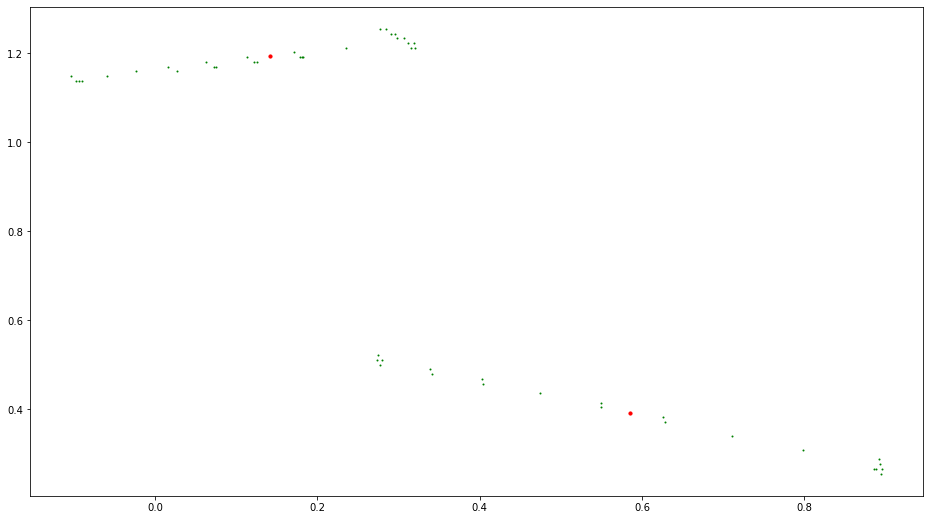

In [6]:
k = 2
centroids = lines_clustering(lines_norm, k)
plt.figure(figsize=(16,9))
plt.scatter(lines_norm[:, 0], lines_norm[:, 1], c='g', s=1)
plt.scatter(centroids[:, 0], centroids[:, 1], c='r', s=10)    
plt.show()

In [7]:
closest = closest_centroid(lines_norm, centroids)
clusters = []

_, count = np.unique(closest, return_counts = True)
for i in range(2):
    clusters.append(np.empty(shape=(count[i], 2), dtype='float32'))

counter = [0, 0]
#add the line to the closest cluster
for i in range (len(closest)):
    c = closest[i]
    clusters[c][counter[c]] = lines[i]
    counter[c] += 1

In [8]:
pointed_image = np.zeros_like(gray)

intersection_coords = np.zeros((len(clusters[0]), len(clusters[1]), 2), dtype='int32')

for i in range (len(clusters[0])):
    for j in range (len(clusters[1])):
        line1 = clusters[0][i]
        line2 = clusters[1][j]
        x,y = hough_line_intersection(line1, line2)
        intersection_coords[i][j][0], intersection_coords[i][j][1] = x, y
        cv2.circle(pointed_image, (x,y), radius=0, color=255, thickness=-1)
imshow_unscaled(pointed_image)
print(intersection_coords[0][0])
print(len(intersection_coords[0][0]))

custom_coords = np.zeros((2,2,2), dtype='int32')
custom_coords = np.array([[[330,20],[770,160]],[[25,300],[570,570]]])
print(custom_coords.shape)
print(custom_coords)
#custom_pointed_image = np.zeros_like(gray)
for i in range(len(custom_coords)):
    for j in range(len(custom_coords[0])):
        x,y = custom_coords[i][j][0],custom_coords[i][j][1]
        print(x,y)
        #cv2.circle(pointed_image,(x,y), radius=10, color=255,thickness=-1)
imshow_unscaled(pointed_image)

[454 423]
2
(2, 2, 2)
[[[330  20]
  [770 160]]

 [[ 25 300]
  [570 570]]]
330 20
770 160
25 300
570 570


In [9]:
# import the necessary packages
import cv2
# initialize the list of reference points and boolean indicating
# whether cropping is being performed or not
refPt = []
cropping = False
def click_and_crop(event, x, y, flags, param):
    # grab references to the global variables
    if event == cv2.EVENT_LBUTTONDOWN:
        refPt.append((x, y))
        


# load the image, clone it, and setup the mouse callback function
clone = img.copy()
cv2.namedWindow("image")
cv2.setMouseCallback("image", click_and_crop)
# keep looping until the 'q' key is pressed
while True:
    # display the image and wait for a keypress
    cv2.imshow("image", img)
    key = cv2.waitKey(1) & 0xFF
    # if the 'r' key is pressed, reset the cropping region
    if key == ord("c"):
        break
# if there are two reference points, then crop the region of interest
# from teh image and display it
if len(refPt) == 2:
    roi = clone[refPt[0][1]:refPt[1][1], refPt[0][0]:refPt[1][0]]
    cv2.imshow("ROI", roi)
    cv2.waitKey(0)
# close all open windows
cv2.destroyAllWindows()

In [10]:
print(refPt)

[(334, 19), (772, 156), (25, 303), (581, 569)]


In [17]:
#single_pointed_image = np.zeros_like(img)
#intersection_coords = np.zeros((len(clusters[0]), len(clusters[1]), 2), dtype='int32')

#warped order: red, blue, white, green
#25,300 = red
#330,20 = blue
#570,570 = white
#770,160 = green

'''
colors = [(255,0,0), (0,255,0), (0,0,255), (255,255,255)]
colors_i = 0
for i in range (2):
    for j in range (2):
        x, y = custom_coords[i][j][0], custom_coords[i][j][1]
        cv2.circle(single_pointed_image, (x,y), radius=0, color=colors[colors_i], thickness=-1)
        colors_i+=1
'''
'''for i in range (1):
    for j in range (1):
        line1 = clusters[0][i]
        line2 = clusters[1][j]
        x,y = hough_line_intersection(line1, line2)
        intersection_coords[i][j][0], intersection_coords[i][j][1] = x, y
        cv2.circle(single_pointed_image, (x,y), radius=0, color=255, thickness=-1)
        '''
#imshow_unscaled(single_pointed_image)
#print(single_pointed_image.shape)

(600, 800, 3)


[0 1 1 1 1 0 1 0 0 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 0 0 0 0 0 1 1 0 0 0 1 0 0
 1 0 0 0 0 1 1 0 0 0 0 0 0]
int64


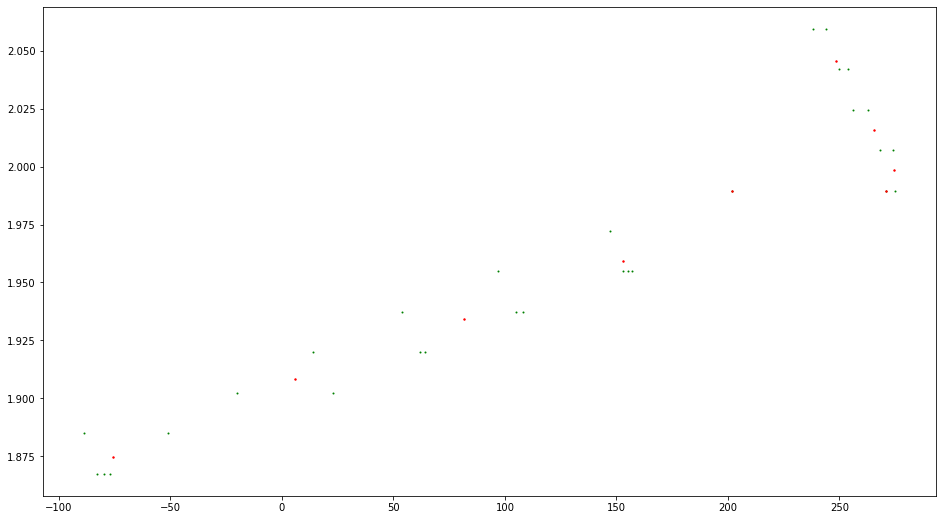

[[248.4         2.0455258]
 [-76.          1.8744837]
 [ 81.666664    1.9344066]
 [271.          1.9896753]
 [  5.6666665   1.9082266]
 [265.5         2.0158553]
 [274.5         1.998402 ]
 [153.          1.9591321]
 [202.          1.9896753]]


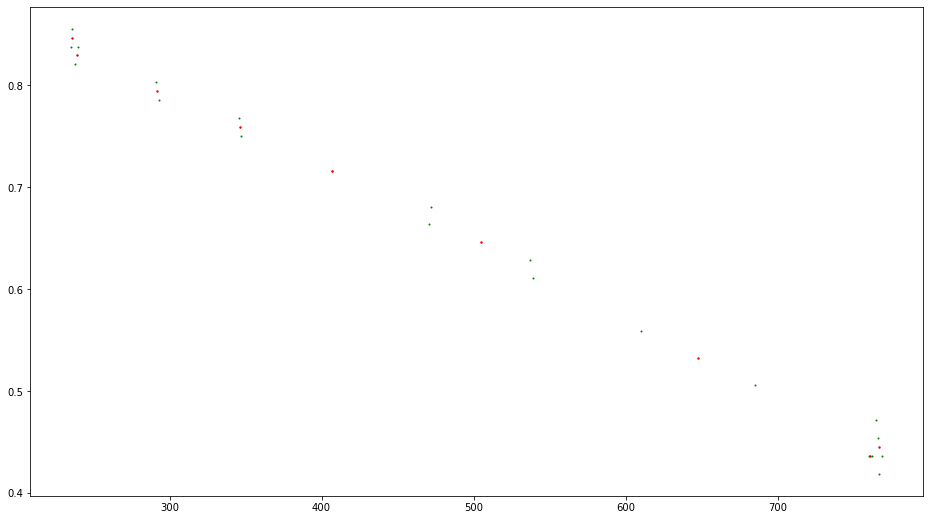

[[248.4         2.0455258]
 [-76.          1.8744837]
 [ 81.666664    1.9344066]
 [271.          1.9896753]
 [  5.6666665   1.9082266]
 [265.5         2.0158553]
 [274.5         1.998402 ]
 [153.          1.9591321]
 [202.          1.9896753]]


In [20]:
#OLD_CODE
#_____________________
#_____________________
print(closest)
print(closest.dtype)
#each cluster should have 9 lines
#use k-means to get the lines
k = 9
centroids_0 = lines_clustering(clusters[0], k)
plt.figure(figsize=(16,9))
plt.scatter(clusters[0][:, 0], clusters[0][:, 1], c='g', s=1)
plt.scatter(centroids_0[:, 0], centroids_0[:, 1], c='r', s=2)
plt.show()
print(centroids_0)
#each cluster should have 9 lines
#use k-means to get the lines
k = 9
centroids_1 = lines_clustering(clusters[1], k)
plt.figure(figsize=(16,9))
plt.scatter(clusters[1][:, 0], clusters[1][:, 1], c='g', s=1)
plt.scatter(centroids_1[:,0], centroids_1[:,1], c='r', s=2)
plt.show()
lines_final = np.zeros_like(gray)
#draw_lines(centroids_0, lines_final)
#draw_lines(centroids_1, lines_final)
draw_lines([[200, 101*np.pi]], lines_final)
draw_lines([[10000,np.pi]], lines_final)
imshow(lines_final)
print(centroids_0)
#IDEA
#Corner detection on detected lines
